<img src='./imagens/USA.png'></img>
<h1 align='center'>USA.GOV data from bit.ly</h1>

## Fala galera, tudo beleza?
Hoje vou fazer uma análise em cima de um dataset criado pelo serviço de encurtamento de URL **bit.ly**.

Em 2011, este serviço fez parceria com o site do governo dos Estados Unidos, USA.GOV, para fornecer um feed de dados anônimos coletados de usuários que encurtam links que terminam com .gov ou .mil.

Cada linha em cada arquivo contém um JSON com informações interessantes.

A inspriração dessa análise vem da leitura do livro **Python for Data Analysis** e escrito por Wes McKinney e publicado pela editora O'Reilly Media, disponínel em <a href='http://a.co/7JZTCYx'> neste link</a>

<h1>Perguntas</h1>

Perguntas que gostaria de saber a resposta:
<br>
<br>
<li>Quantidade total de usuários que realizaram o encurtamento, segundo este <i>dataset</i>.</li>
<li>Quantidade total de usuários por região?</li>
<li>Qual o sistema operacional mais utilizado?</li>
<li>Qual a extensão mais usada, .gov ou .mil?</li>

## Configurações iniciais

In [2]:
# importando as blibliotecas para trabalhar com os dados
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno as mn
import gc
import simplejson as json

# personalizando algumas configurações.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.2f}'.format
rc={'savefig.dpi':75,
'figure.autolayout': False,
'figure.figsize' :[16,8],
'axes.labelsize' : 18,
'axes.titlesize' : 18,
'font.size' : 18,
'lines.linewidth' : 2.0,
'lines.markersize' : 8,
'legend.fontsize' : 16,
'xtick.labelsize' : 16,
'ytick.labelsize' : 16}
sns.set(style='dark', rc = rc)
default_color = '#0277bd'
colormap = plt.cm.cool

# magic
%matplotlib inline

## Data Cleaning e Data Wrangling

### DATA

In [3]:
# importa do os dados do dataset
path = "./data/usa/usagov_bitly_data2012.txt"
data = [json.loads(line) for line in open(path)]

In [4]:
## Visualizando os dados
data[0]

{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
 'al': 'en-US,en;q=0.8',
 'c': 'US',
 'cy': 'Danvers',
 'g': 'A6qOVH',
 'gr': 'MA',
 'h': 'wfLQtf',
 'hc': 1331822918,
 'hh': '1.usa.gov',
 'l': 'orofrog',
 'll': [42.576698, -70.954903],
 'nk': 1,
 'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
 't': 1331923247,
 'tz': 'America/New_York',
 'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991'}

Aqui dá pra ver algums informações imporantes que será utilizado nas análises. 
Vou utilizar apenas algumas que considero importantes, descristas na tabela abaixo:

|Chave | Definição      | Valor                                   |
|:-----|:---------------|:----------------------------------------|
| c    | country        | País do acesso                          |
| cy   | city           | Cidade de acesso                        |
| a    | access         | informações da maquina que fez o acesso |
| al   | access language| lingaguem                               |
| hh   | dominy         | dominio que foi encurtado               |
| tz   | timezone       | região onde foi feito o acesso          |
| u    | url            | url encurtada                           |

In [5]:
# Criando um dataframe para manipular os dados
df = pd.DataFrame(data)
print('Este dataset possui {} linhas e {} colunas'.format(df.shape[0], df.shape[1]))
df.head()

Este dataset possui 3560 linhas e 18 colunas


,_heartbeat_,a,al,c,cy,g,gr,h,hc,hh,kw,l,ll,nk,r,t,tz,u
0,nan,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Danvers,A6qOVH,MA,wfLQtf,1331822918.00,1.usa.gov,NaN,orofrog,"[42.576698, -70.954903]",1.00,http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...,1331923247.00,America/New_York,http://www.ncbi.nlm.nih.gov/pubmed/22415991
1,nan,GoogleMaps/RochesterNY,NaN,US,Provo,mwszkS,UT,mwszkS,1308262393.00,j.mp,NaN,bitly,"[40.218102, -111.613297]",0.00,http://www.AwareMap.com/,1331923249.00,America/Denver,http://www.monroecounty.gov/etc/911/rss.php
2,nan,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,en-US,US,Washington,xxr3Qb,DC,xxr3Qb,1331919941.00,1.usa.gov,NaN,bitly,"[38.9007, -77.043098]",1.00,http://t.co/03elZC4Q,1331923250.00,America/New_York,http://boxer.senate.gov/en/press/releases/0316...
3,nan,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,pt-br,BR,Braz,zCaLwp,27,zUtuOu,1331923068.00,1.usa.gov,NaN,alelex88,"[-23.549999, -46.616699]",0.00,direct,1331923249.00,America/Sao_Paulo,http://apod.nasa.gov/apod/ap120312.html
4,nan,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Shrewsbury,9b6kNl,MA,9b6kNl,1273672411.00,bit.ly,NaN,bitly,"[42.286499, -71.714699]",0.00,http://www.shrewsbury-ma.gov/selco/,1331923251.00,America/New_York,http://www.shrewsbury-ma.gov/egov/gallery/1341...


### Separando apenas as colunas que quero

In [6]:
# verificando os indices
df.columns

Index(['_heartbeat_', 'a', 'al', 'c', 'cy', 'g', 'gr', 'h', 'hc', 'hh', 'kw',
       'l', 'll', 'nk', 'r', 't', 'tz', 'u'],
      dtype='object')

In [7]:
df.drop(['_heartbeat_','g','gr','h','hc','kw','l','ll','nk','r','t'], axis=1, inplace = True)
df.head()

,a,al,c,cy,hh,tz,u
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Danvers,1.usa.gov,America/New_York,http://www.ncbi.nlm.nih.gov/pubmed/22415991
1,GoogleMaps/RochesterNY,NaN,US,Provo,j.mp,America/Denver,http://www.monroecounty.gov/etc/911/rss.php
2,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,en-US,US,Washington,1.usa.gov,America/New_York,http://boxer.senate.gov/en/press/releases/0316...
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,pt-br,BR,Braz,1.usa.gov,America/Sao_Paulo,http://apod.nasa.gov/apod/ap120312.html
4,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Shrewsbury,bit.ly,America/New_York,http://www.shrewsbury-ma.gov/egov/gallery/1341...


### Ajustando o dataset

In [8]:
df.columns = ['Acesso','Lingua','País','Cidade', 'Domínio', 'Timezone','Url']
df.head()

,Acesso,Lingua,País,Cidade,Domínio,Timezone,Url
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Danvers,1.usa.gov,America/New_York,http://www.ncbi.nlm.nih.gov/pubmed/22415991
1,GoogleMaps/RochesterNY,NaN,US,Provo,j.mp,America/Denver,http://www.monroecounty.gov/etc/911/rss.php
2,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,en-US,US,Washington,1.usa.gov,America/New_York,http://boxer.senate.gov/en/press/releases/0316...
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,pt-br,BR,Braz,1.usa.gov,America/Sao_Paulo,http://apod.nasa.gov/apod/ap120312.html
4,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Shrewsbury,bit.ly,America/New_York,http://www.shrewsbury-ma.gov/egov/gallery/1341...


### Verificando dados inválidos

In [9]:
# Verificando quais tipos de dados estamos trabalhando
df.dtypes

Acesso      object
Lingua      object
País        object
Cidade      object
Domínio     object
Timezone    object
Url         object
dtype: object

In [10]:
# Que informação pode obter pel describe?
df.describe()

,Acesso,Lingua,País,Cidade,Domínio,Timezone,Url
count,3440,3094,2919,2919,3440,3440,3440
unique,761,172,71,1014,21,97,736
top,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:10.0.2)...,"en-us,en;q=0.5",US,Provo,1.usa.gov,America/New_York,https://www.nysdot.gov/rexdesign/design/commun...
freq,309,855,2305,121,2781,1251,836


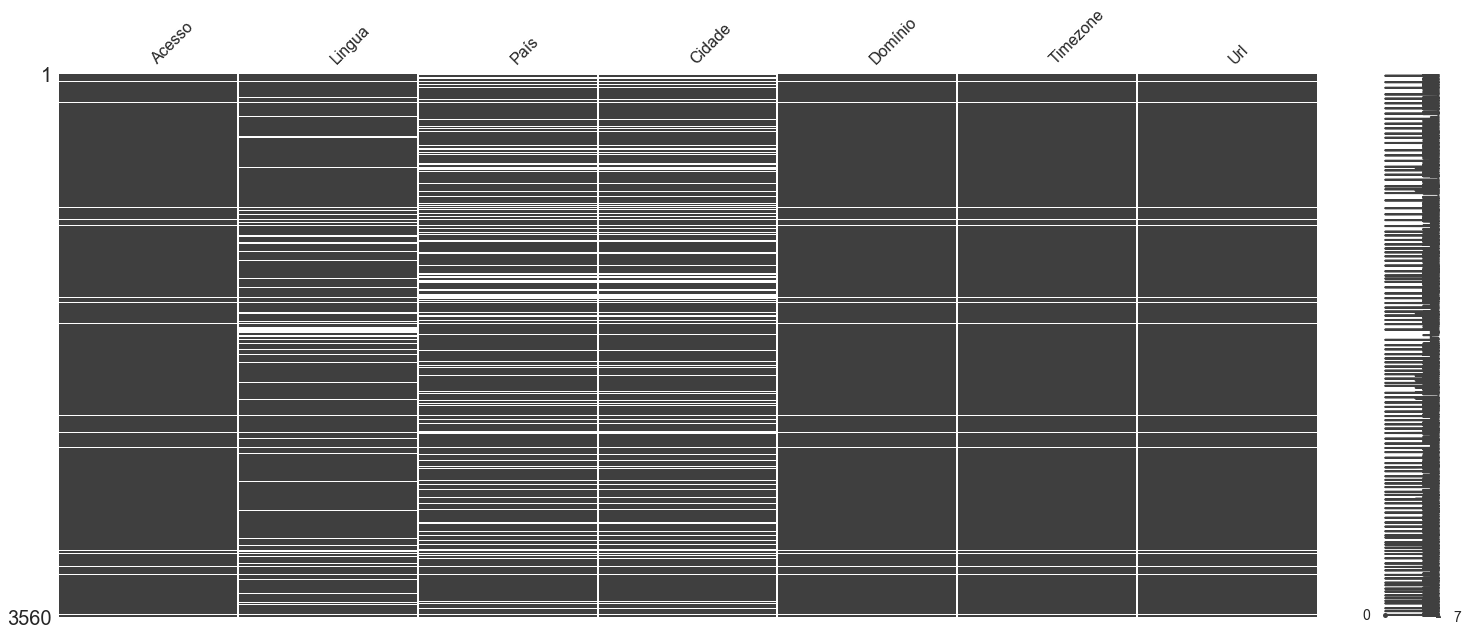

In [11]:
# Verificando os daos NaN
# biblioteca missingno 
mn.matrix(df)

#### Limpando dados de Acesso que são inválidos

O tipo de tratamento é definido de dados inválidos é de escolha própria. Existe varias abordagens, nesta em questão eu vou excluir a linha do dataframe que possui os dados de acesso inválido. 

In [12]:
# Pega os valores nulos
na_values = df['Acesso'].isnull()
na_index = df['Acesso'][na_values].index
na_index

Int64Index([  13,   55,   92,  135,  163,  193,  226,  261,  295,  327,
            ...
            3348, 3371, 3390, 3415, 3433, 3451, 3467, 3499, 3518, 3543],
           dtype='int64', length=120)

In [13]:
# remove a linha
df.drop(na_index, inplace = True)

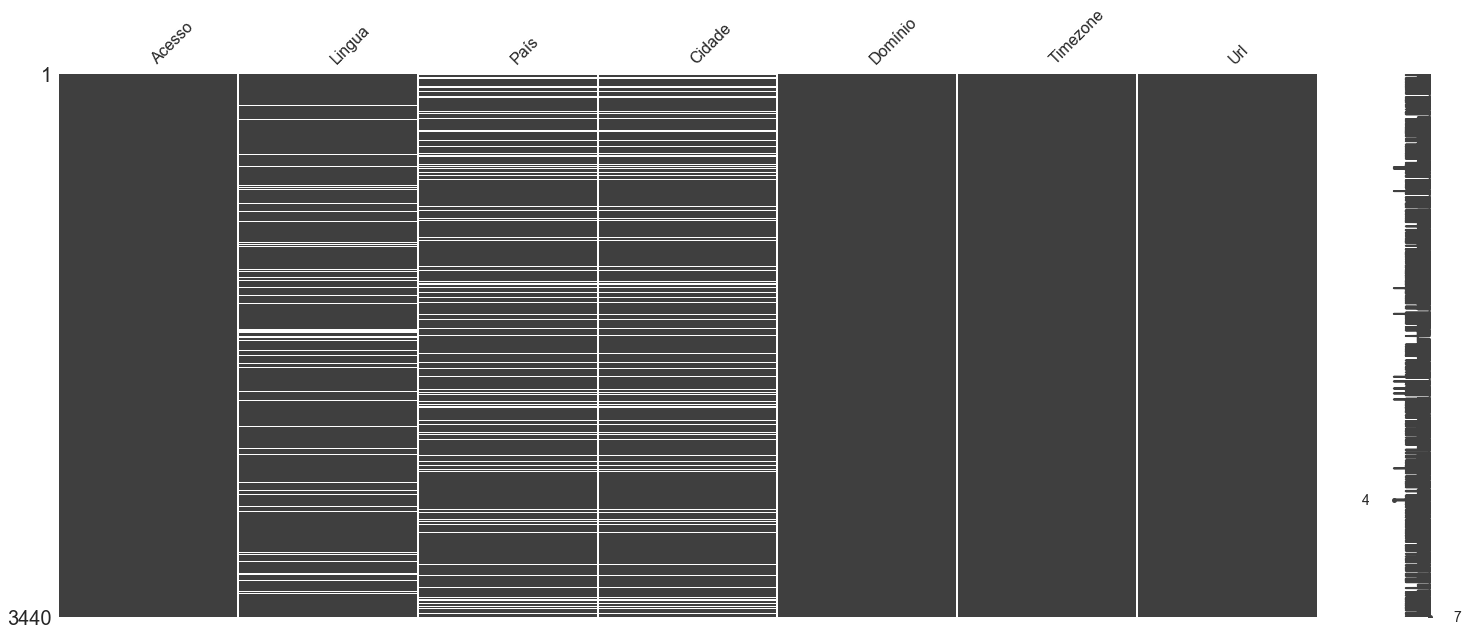

In [14]:
# Verificando os dados NaN
# biblioteca missingno 
mn.matrix(df)

#### Limpando dados de Lingua que são inválidos

Para tratar os dados inválidos da coluna **Lingua** eu vou usar a lingua de maior frêquencia. Acredito que esta será uma boa abordagem. Porém dependendo da análise isto pode causar diferença.

In [15]:
# Contando as linguas
df['Lingua'].value_counts()[:5]

en-us,en;q=0.5    855
en-us             799
en-US,en;q=0.8    492
en-US             331
en                 45
Name: Lingua, dtype: int64

In [16]:
# Pega os valores nulos
na_values = df['Lingua'].isnull()
na_index = df['Lingua'][na_values].index
na_index

Int64Index([   1,   18,   82,  104,  112,  125,  156,  160,  164,  165,
            ...
            3465, 3469, 3478, 3509, 3520, 3539, 3541, 3552, 3557, 3558],
           dtype='int64', length=346)

In [17]:
# Verifincando se realmente esta nulo
df.loc[1]

Acesso                           GoogleMaps/RochesterNY
Lingua                                              NaN
País                                                 US
Cidade                                            Provo
Domínio                                            j.mp
Timezone                                 America/Denver
Url         http://www.monroecounty.gov/etc/911/rss.php
Name: 1, dtype: object

In [18]:
# alterando os valores que eram nulos pelo de maior frenquêcia
df['Lingua'].replace([df['Lingua'][na_index]], 'en-us,en;q=0.5', inplace=True)
df.loc[1]

Acesso                           GoogleMaps/RochesterNY
Lingua                                   en-us,en;q=0.5
País                                                 US
Cidade                                            Provo
Domínio                                            j.mp
Timezone                                 America/Denver
Url         http://www.monroecounty.gov/etc/911/rss.php
Name: 1, dtype: object

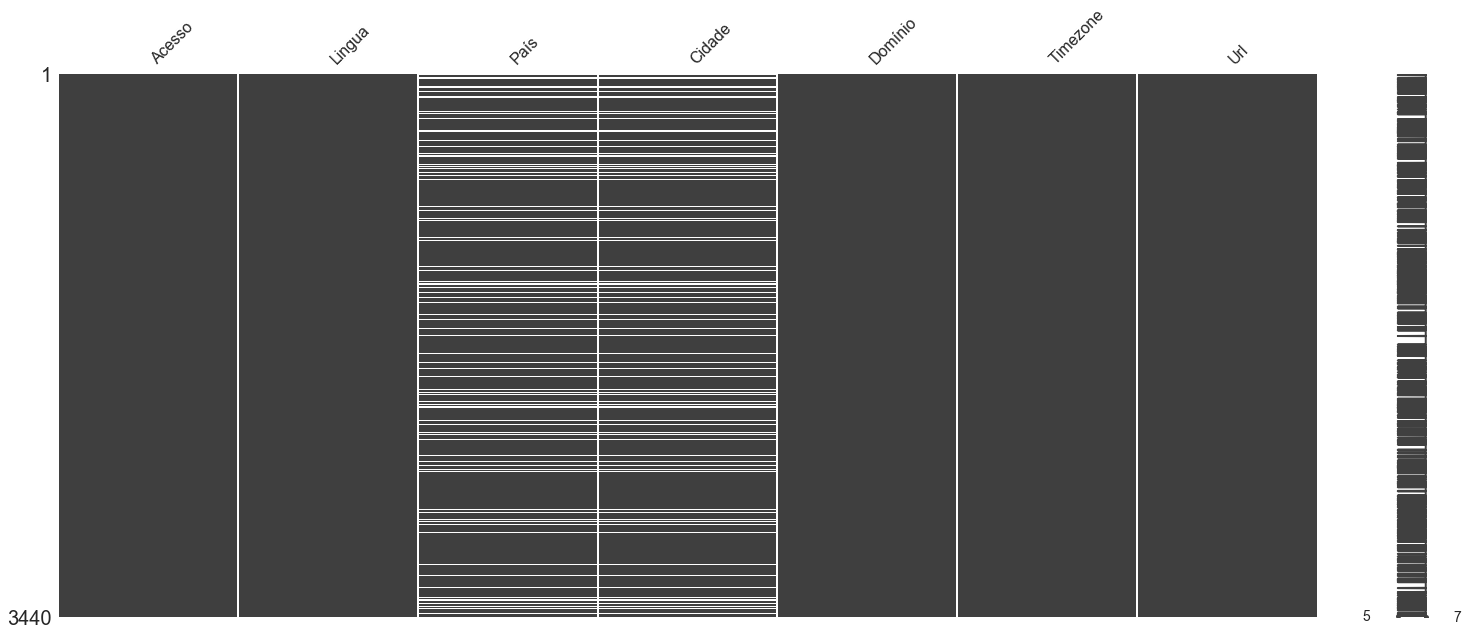

In [19]:
# Verificando os dados NaN
# biblioteca missingno 
mn.matrix(df)

In [20]:
# Esta função normaliza as linguas do dataset.
# Vou considerar apenas as mais relevantes, ou seja, as que tiveram maior frequência.

def norm_lingua(lingua):
    if 'en' in lingua:
        return 'Inglês'
    elif 'pt' in lingua:
        return 'Português'
    elif 'ja' in lingua:
        return 'Japonês'
    elif 'es' in lingua:
        return 'Espanhol'
    elif 'fr' in lingua:
        return 'Francês'
    elif 'nl' in lingua:
        return 'Holandês'
    elif 'pl' in lingua:
        return 'Polonês'
    elif 'ch' in lingua:
        return 'Chinês'
    elif 'de' in lingua:
        return 'Alemão'
    elif 'ru' in lingua:
        return 'Russo'
    else:
        return 'Outras'
    

In [21]:
# normalizando as linguas
df['Lingua'] = df['Lingua'].apply(norm_lingua)

In [22]:
df.head()

,Acesso,Lingua,País,Cidade,Domínio,Timezone,Url
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Inglês,US,Danvers,1.usa.gov,America/New_York,http://www.ncbi.nlm.nih.gov/pubmed/22415991
1,GoogleMaps/RochesterNY,Inglês,US,Provo,j.mp,America/Denver,http://www.monroecounty.gov/etc/911/rss.php
2,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,Inglês,US,Washington,1.usa.gov,America/New_York,http://boxer.senate.gov/en/press/releases/0316...
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,Português,BR,Braz,1.usa.gov,America/Sao_Paulo,http://apod.nasa.gov/apod/ap120312.html
4,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Inglês,US,Shrewsbury,bit.ly,America/New_York,http://www.shrewsbury-ma.gov/egov/gallery/1341...


#### Limpando dados de País que são inválidos

Para tratar os dados inválidos da coluna **País** eu vou usar a mesma abordagem da lingua, frequência. Porém dependendo da análise isto pode causar diferença.

In [23]:
# Contando os países
print('País com maior acesso: {}'.format(df['País'].value_counts().argmax()))
df['País'].value_counts()[:10]

País com maior acesso: US


US    2305
GB      74
CA      60
JP      37
ES      37
BR      35
DE      28
IT      27
NL      22
MX      19
Name: País, dtype: int64

In [24]:
# Pega os valores nulos
na_values = df['País'].isnull()
na_index = df['País'][na_values].index
na_index

Int64Index([   7,    8,    9,   28,   29,   34,   35,   37,   46,   47,
            ...
            3495, 3501, 3503, 3504, 3505, 3512, 3513, 3531, 3536, 3551],
           dtype='int64', length=521)

In [25]:
df.loc[7]

Acesso      Mozilla/5.0 (Windows NT 6.1; rv:2.0.1) Gecko/2...
Lingua                                                 Inglês
País                                                     None
Cidade                                                    NaN
Domínio                                             1.usa.gov
Timezone                                                     
Url         http://www.nasa.gov/mission_pages/nustar/main/...
Name: 7, dtype: object

In [26]:
# alterando os valores que eram nulos pelo de maior frenquêcia
df['País'].replace([df['País'][na_index]], 'US', inplace=True)
df.loc[7]

Acesso      Mozilla/5.0 (Windows NT 6.1; rv:2.0.1) Gecko/2...
Lingua                                                 Inglês
País                                                       US
Cidade                                                    NaN
Domínio                                             1.usa.gov
Timezone                                                     
Url         http://www.nasa.gov/mission_pages/nustar/main/...
Name: 7, dtype: object

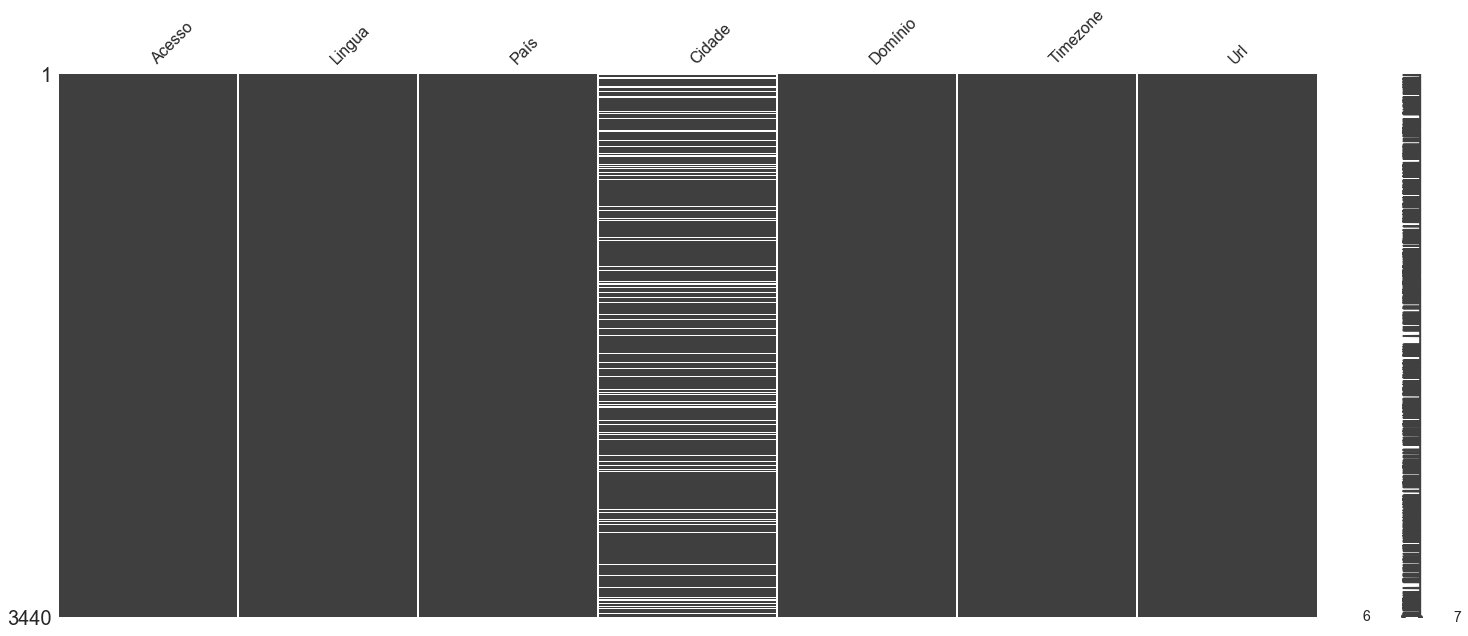

In [27]:
# Verificando os dados NaN
# biblioteca missingno 
mn.matrix(df)

#### Limpando dados de Cidade que são inválidos

Para tratar os dados inválidos da coluna **Cidade** eu vou usar a mesma abordagem anterior, frequência. Porém dependendo da análise isto pode causar diferença.

In [28]:
# Contando as cidades
print('Cidade com maior acesso: {}'.format(df['Cidade'].value_counts().argmax()))
df['Cidade'].value_counts()[:10]

Cidade com maior acesso: Provo


Provo           121
White Plains    104
Washington       98
Palo Alto        68
Shrewsbury       46
Acworth          38
Dallas           33
Paramus          32
Nogata           29
Los Angeles      28
Name: Cidade, dtype: int64

### What's hell is it 'Provo'?

"Provo é uma cidade localizada no estado norte-americano do Utah, no Condado de Utah. Foi fundada em 1849, e incorporada em abril de 1850. Provo fica a cerca de 69 km ao sul de Salt Lake City, ao longo da Frente Wasatch". <a href='https://pt.wikipedia.org/wiki/Provo'> Wikipédia</a>.

<img src='./imagens/provo.jpg'></img>

In [29]:
# Pega os valores nulos
na_values = df['Cidade'].isnull()
na_index = df['Cidade'][na_values].index
na_index

Int64Index([   7,    8,    9,   28,   29,   34,   35,   37,   46,   47,
            ...
            3495, 3501, 3503, 3504, 3505, 3512, 3513, 3531, 3536, 3551],
           dtype='int64', length=521)

In [30]:
df.loc[7]

Acesso      Mozilla/5.0 (Windows NT 6.1; rv:2.0.1) Gecko/2...
Lingua                                                 Inglês
País                                                       US
Cidade                                                    NaN
Domínio                                             1.usa.gov
Timezone                                                     
Url         http://www.nasa.gov/mission_pages/nustar/main/...
Name: 7, dtype: object

In [31]:
# alterando os valores que eram nulos pelo de maior frenquêcia
df['Cidade'].replace([df['Cidade'][na_index]], 'Provo', inplace=True)
df.loc[7]

Acesso      Mozilla/5.0 (Windows NT 6.1; rv:2.0.1) Gecko/2...
Lingua                                                 Inglês
País                                                       US
Cidade                                                  Provo
Domínio                                             1.usa.gov
Timezone                                                     
Url         http://www.nasa.gov/mission_pages/nustar/main/...
Name: 7, dtype: object

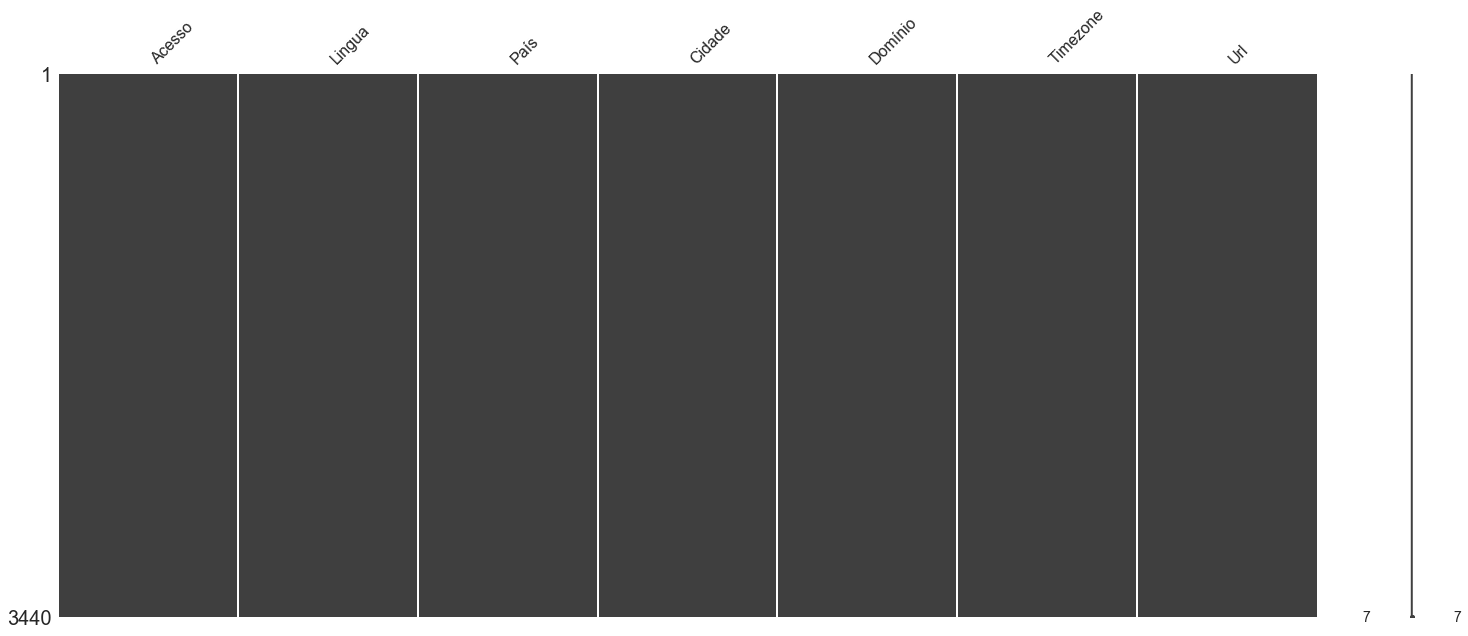

In [32]:
# Verificando os dados NaN
# biblioteca missingno 
mn.matrix(df)

## Pergunta 1

Quantidade total de usuários que realizaram o encurtamento?

In [33]:
df.describe()

,Acesso,Lingua,País,Cidade,Domínio,Timezone,Url
count,3440,3440,3440,3440,3440,3440,3440
unique,761,10,71,1014,21,97,736
top,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:10.0.2)...,Inglês,US,Provo,1.usa.gov,America/New_York,https://www.nysdot.gov/rexdesign/design/commun...
freq,309,3257,2826,642,2781,1251,836


Após o dataset limpo restaram 3440 acessos.

## Pergunta 2

Quantidade total de usuários por região?

In [34]:
# contando as regiões e ordenando em ordem decrescente.
df['Timezone'].value_counts().sort_values(ascending=False)[:10]

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: Timezone, dtype: int64

### Olha que interessante!!!! 
São Paulo está entre os TOP 10 de acesso.
Outro ponto importante é que existe 521 acessos de uma área não marcada como inválida anteriormente. 
Provamente existe algum caracter nesta. Vamos tratar isso como Outras.

In [35]:
# Seleciona todos os indeces onde timezone é uma string vazia
df['Timezone'][df['Timezone'] == ''][:5]

7     
8     
9     
28    
29    
Name: Timezone, dtype: object

In [36]:
# verificando se está vazio
df.loc[7]

Acesso      Mozilla/5.0 (Windows NT 6.1; rv:2.0.1) Gecko/2...
Lingua                                                 Inglês
País                                                       US
Cidade                                                  Provo
Domínio                                             1.usa.gov
Timezone                                                     
Url         http://www.nasa.gov/mission_pages/nustar/main/...
Name: 7, dtype: object

In [37]:
# Alterando os valores vazios
df['Timezone'][df['Timezone'] == ''] = 'Outras'
timezones_count = df['Timezone'].value_counts().sort_values(ascending=False)
timezones_count.head(10)

America/New_York       1251
Outras                  521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: Timezone, dtype: int64

Vamos fazer um gráfico para que a análise fique melhor. Porém vamos pegar apenas os locais com maior frequência

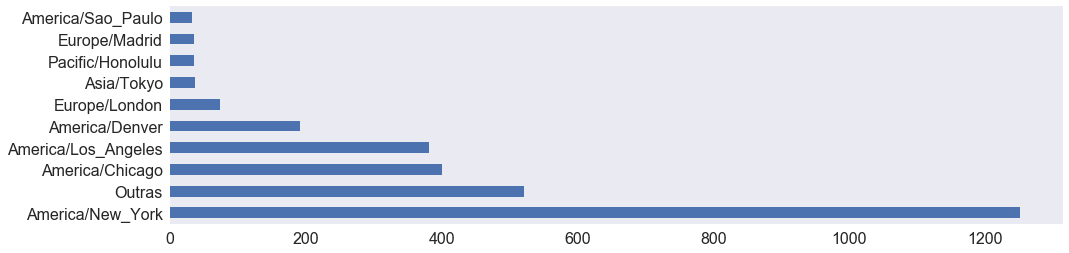

In [38]:
timezones_count[:10].plot(figsize=(16,4), kind='barh')
plt.show()

## Pergunta 3

Qual o sistema operacional mais utilizado?

In [39]:
# Verificando a quantidade 
df['Acesso'].value_counts().sort_values(ascending=False)[:10]

Mozilla/5.0 (Windows NT 6.1; WOW64; rv:10.0.2) Gecko/20100101 Firefox/10.0.2                                              309
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.79 Safari/535.11               229
GoogleMaps/RochesterNY                                                                                                    121
Mozilla/5.0 (Windows NT 5.1) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.79 Safari/535.11                       93
Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)                                                     92
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.79 Safari/535.11                       81
Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US; rv:1.9.2.28) Gecko/20120306 Firefox/3.6.28                                 79
Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/20100101 Firefox/10.0.2                                                 

Já da pra notar que Windons é o vencedor. Vamos tratar mais ainda os dados.

In [40]:
# Selecionando entre Windows e outros S.O's
sistema_op = np.where(df['Acesso'].str.contains('Windows'),'Windows', 'Outros')
sistema_op[:10]

array(['Windows', 'Outros', 'Windows', 'Outros', 'Windows', 'Windows',
       'Windows', 'Windows', 'Outros', 'Windows'],
      dtype='<U7')

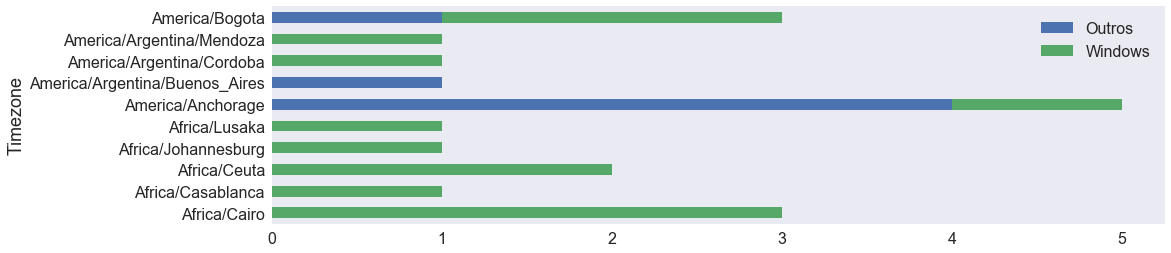

In [41]:
# Agrupando região por sistema operacional utilizado
regiao_por_so = df.groupby(['Timezone', sistema_op]) 
quantidade_reg_so = regiao_por_so.size().unstack().fillna(0)
quantidade_reg_so[:10].plot(figsize=(16,4), kind='barh', stacked=True)
plt.show()

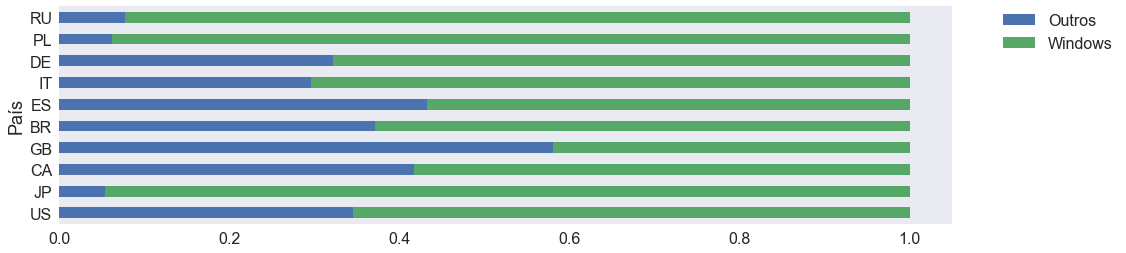

In [42]:
# Agrupando região por sistema operacional utilizado
pais_por_so = df.groupby(['País', sistema_op]) 
quantidade_pais_so = pais_por_so.size().unstack().fillna(0)
quantidade_pais_so = quantidade_pais_so.sort_values('Windows', ascending=False)
normalizado = quantidade_pais_so.div(quantidade_pais_so.sum(1), axis=0)
normalizado[:10].plot(figsize=(16,4), kind='barh', stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Pergunta 4

Qual a extensão mais usada, .gov ou .mil?

In [46]:
# Verificando a quantidade 
quantidade_dominios = df['Domínio'].value_counts().sort_values(ascending=False)
quantidade_dominios

1.usa.gov      2781
bit.ly          261
go.nasa.gov     236
j.mp             82
on.doi.gov       19
gr.pn            13
ds.io            12
bitly.com         9
aash.to           7
sfg.ly            3
go.ostp.gov       3
lat.ms            3
brow.se.com       2
erlyedt.in        2
prks.org          1
mjr.mn            1
gates.ly          1
lsfhs.com         1
jvel.in           1
cbsloc.al         1
ibm.co            1
Name: Domínio, dtype: int64

Bom, vemos que no dataset não tem a extransão .mil

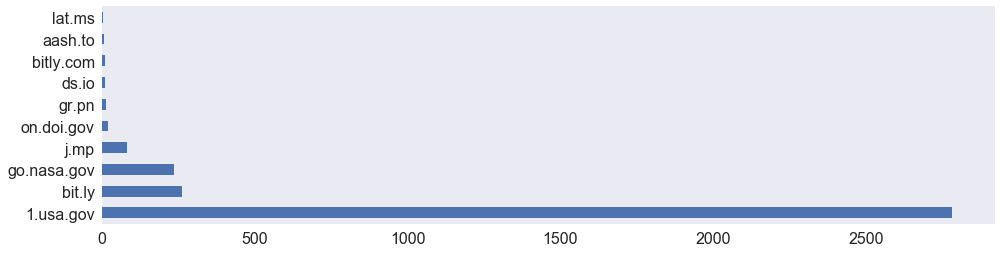

In [54]:
quantidade_dominios = quantidade_dominios.sort_values(ascending=False)
quantidade_dominios[:10].plot(figsize=(16,4), kind='barh', stacked=True)
plt.show()

In [68]:
df.columns

Index(['Acesso', 'Lingua', 'País', 'Cidade', 'Domínio', 'Timezone', 'Url'], dtype='object')

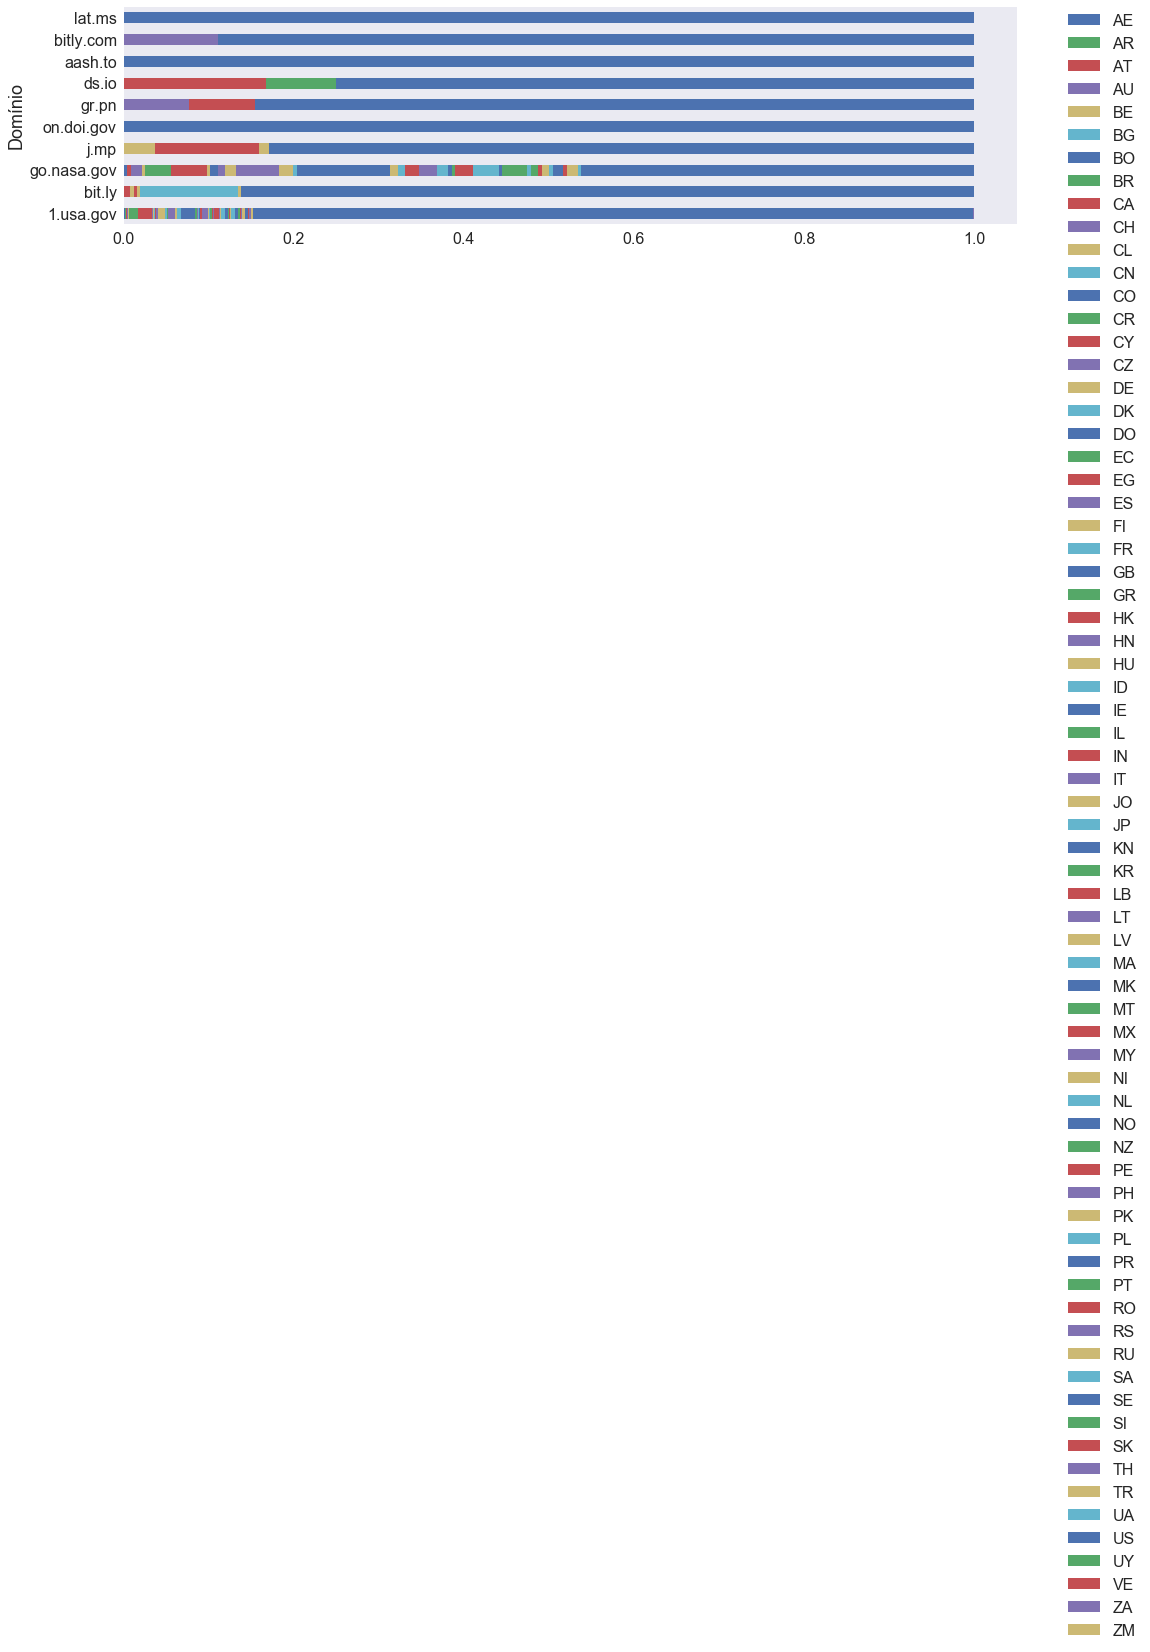

In [67]:
# Agrupando Dominio por país utilizado
dominios = df.groupby(['Domínio', 'País']) 
dominios_pais = dominios.size().unstack().fillna(0)
dominios_pais = dominios_pais.sort_values(by='US', ascending=False)
normalizado = dominios_pais.div(dominios_pais.sum(1), axis=0)
normalizado[:10].plot(figsize=(16,4), kind='barh', stacked=True, legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

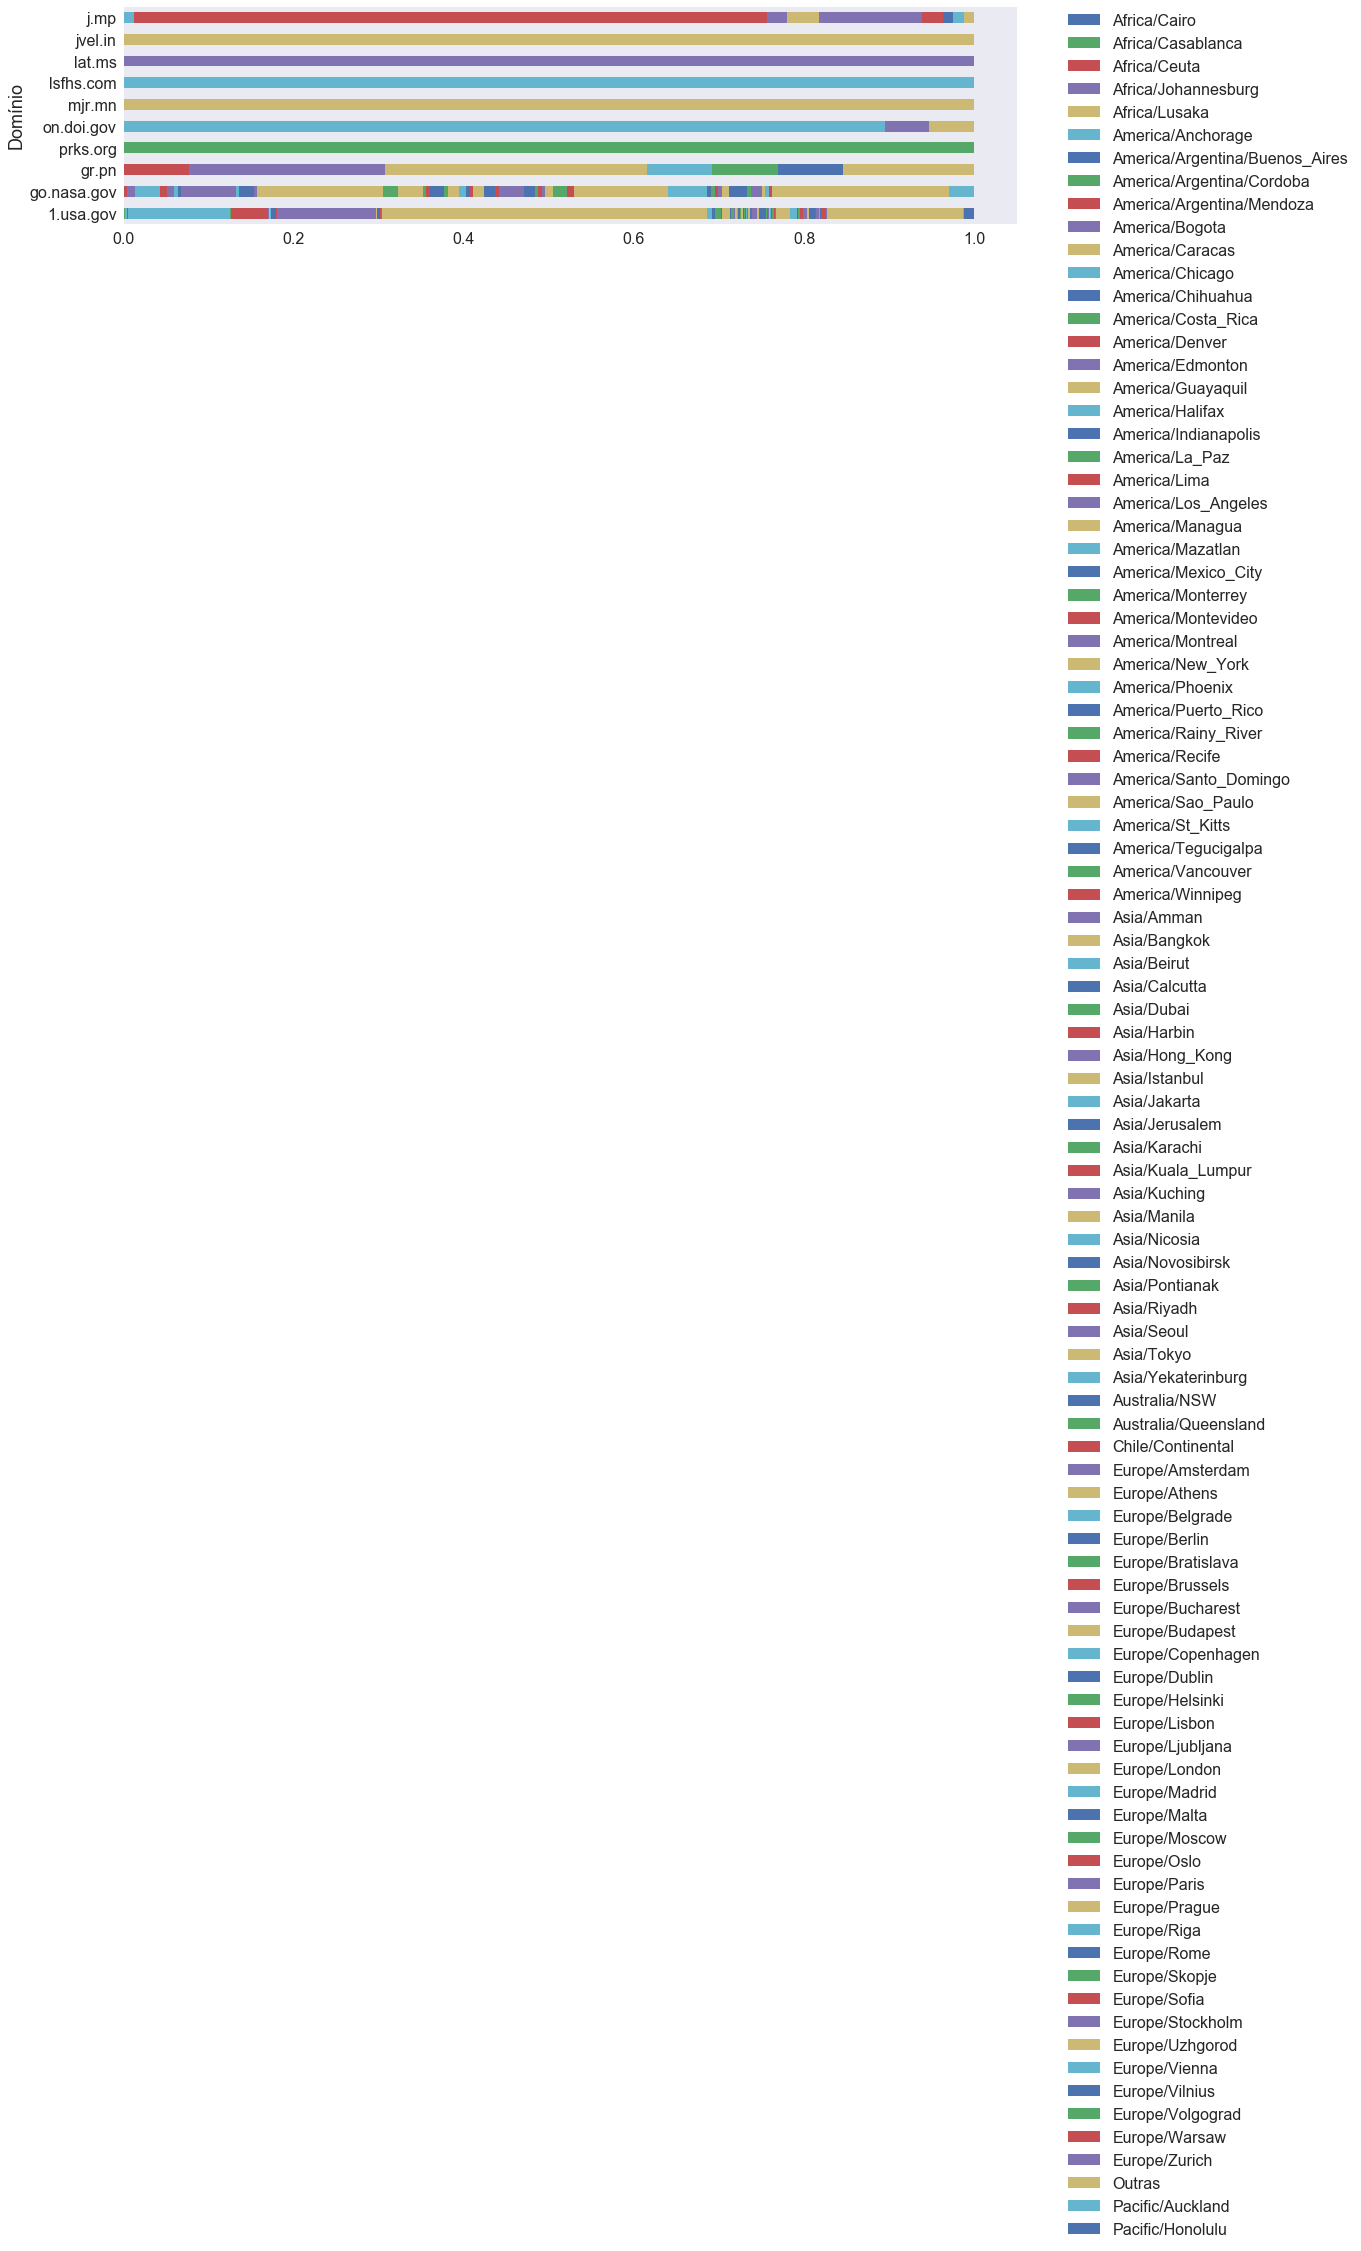

In [75]:
# Agrupando Dominio por Timezone utilizado
dominios = df.groupby(['Domínio', 'Timezone']) 
dominios_pais = dominios.size().unstack().fillna(0)
dominios_pais = dominios_pais.sort_values(by='America/Sao_Paulo', ascending=False)
normalizado = dominios_pais.div(dominios_pais.sum(1), axis=0)
normalizado[:10].plot(figsize=(16,4), kind='barh', stacked=True, legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# É isso ai galera, abraços!